# Cross-Encoder Zero-Shot Baseline

**Goal**: Score every transcript chunk against its specific Skill Description using a pre-trained Cross-Encoder.

**Model**: `cross-encoder/ms-marco-MiniLM-L-6-v2`

**Approach**:
1. Create pairs of `(Skill Description, Chunk Text)`.
2. Feed pairs into the Cross-Encoder.
3. Save scores as a baseline for comparison.

In [ ]:
import pandas as pd
import yaml
import torch
from pathlib import Path
from sentence_transformers import CrossEncoder
from tqdm.auto import tqdm
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

c:\Users\jaime\OneDrive\BU\1st Semester\Deep Learning\Deep Learning Project\Deep-Learning-Project\dl-project-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 1. Load Data

In [ ]:
# Paths
DATA_DIR = Path('../data/processed')
CONFIG_PATH = Path('../config/skills.yml')
RESULTS_DIR = Path('../results/baselines')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Load CSVs
chunks_df = pd.read_csv(DATA_DIR / 'transcript_chunks.csv')
video_skills_df = pd.read_csv(DATA_DIR / 'video_skill_candidates.csv')

# Load Skills Config
with open(CONFIG_PATH, 'r') as f:
    skills_config = yaml.safe_load(f)

# Create a map of skill_id -> description
skill_map = {}
for skill in skills_config['skills']:
    # We use Name + Description for the query to give the model full context
    skill_map[skill['skill_id']] = f"{skill['name']}: {skill['description']}"

print(f"Loaded {len(chunks_df):,} chunks.")
print(f"Loaded {len(video_skills_df)} video-skill mappings.")
print(f"Loaded {len(skill_map)} skills.")

Loaded 12,170 chunks.
Loaded 473 video-skill mappings.
Loaded 8 skills.


## 2. Prepare Pairs

In [ ]:
# Merge chunks with their assigned skill
# We merge on 'video_id' to assign the correct skill to every chunk in that video
merged_df = chunks_df.merge(video_skills_df[['video_id', 'skill_id']], on='video_id', how='inner')

# Map the skill description
merged_df['query_text'] = merged_df['skill_id'].map(skill_map)

# Filter out any missing skills (safety check)
merged_df = merged_df.dropna(subset=['query_text'])

# Create input pairs for the model: [Query, Document]
model_inputs = merged_df[['query_text', 'text']].values.tolist()

print(f"Prepared {len(model_inputs):,} pairs for scoring.")
print(f"Example Pair:\nQuery: {model_inputs[0][0]}\nChunk: {model_inputs[0][1][:100]}...")

Prepared 12,198 pairs for scoring.
Example Pair:
Query: NumPy array manipulation: Learn how to create, manipulate, and operate on NumPy arrays including indexing, slicing, reshaping, broadcasting, and performing mathematical operations on multidimensional arrays.
Chunk: hello everyone and welcome to the ultimate guide to numpy arrays where numpy is a popular python lib...


## 3. Load Model & Predict

In [ ]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-6-v2'

logger.info(f"Loading model: {MODEL_NAME}...")
model = CrossEncoder(MODEL_NAME, device=device)

logger.info("Starting prediction...")

# Predict scores
scores = model.predict(
    model_inputs,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

logger.info("Prediction complete.")

## 4. Save Results

In [ ]:
# Add scores back to dataframe
merged_df['score'] = scores

# Select relevant columns
output_df = merged_df[['video_id', 'chunk_id', 'skill_id', 'score']]

# Save
output_path = RESULTS_DIR / 'zeroshot_scores.csv'
output_df.to_csv(output_path, index=False)

print(f" Saved zero-shot scores to: {output_path}")
print(output_df.head())

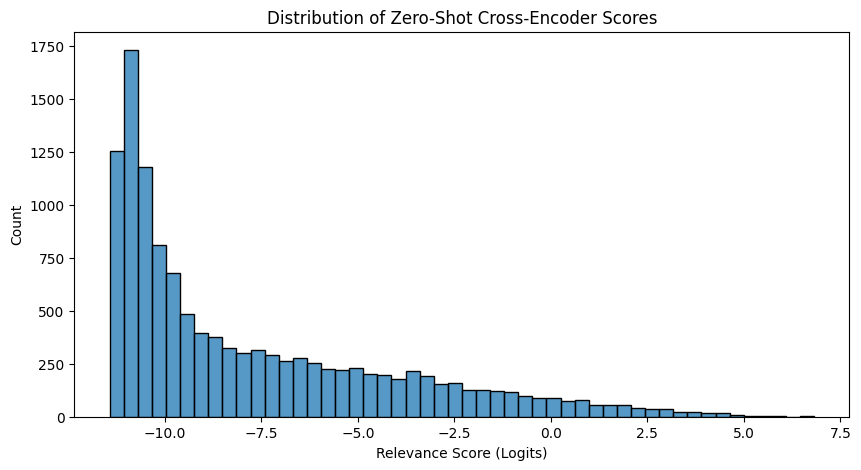

In [ ]:
# Quick distribution check
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(output_df['score'], bins=50)
plt.title('Distribution of Zero-Shot Cross-Encoder Scores')
plt.xlabel('Relevance Score (Logits)')
plt.show()